In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
from concurrent import futures
import threading
import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from collections import Counter
import matplotlib.pyplot as plt

In [5]:
#Data Loading
# set root as images folder path of dataset

root ="/content/drive/MyDrive/Colab_Notebooks/Kidneystone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"

# read dataset
base_dir = os.path.join(root)
cyst_dir = os.path.join(base_dir,'Cyst')
normal_dir = os.path.join(base_dir,'Normal')
stone_dir = os.path.join(base_dir,'Stone')
tumor_dir = os.path.join(base_dir,'Tumor')

cyst_files = glob.glob(cyst_dir+'/*.jpg')
normal_files = glob.glob(normal_dir+'/*.jpg')
stone_files = glob.glob(stone_dir+'/*.jpg')
tumor_files = glob.glob(tumor_dir+'/*.jpg')

len(cyst_files), len(normal_files),len(stone_files), len(tumor_files) 

(3728, 5077, 1377, 2283)

In [6]:
#Check top 5 rows of data
np.random.seed(42)

files_df = pd.DataFrame({
    'filename': cyst_files + normal_files + stone_files + tumor_files,
    'label': ['Cyst'] * len(cyst_files) + ['Normal'] * len(normal_files) + ['Stone']* len(stone_files) + ['Tumor'] * len(tumor_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)

files_df.head()

,filename,label
0,/content/drive/MyDrive/Colab_Notebooks/Kidneys...,Normal
1,/content/drive/MyDrive/Colab_Notebooks/Kidneys...,Normal
2,/content/drive/MyDrive/Colab_Notebooks/Kidneys...,Cyst
3,/content/drive/MyDrive/Colab_Notebooks/Kidneys...,Stone
4,/content/drive/MyDrive/Colab_Notebooks/Kidneys...,Stone


Data Preprocessing

In [7]:
# Data Splitting
# Partition dataset into training(60),testing(30),validation(10) 
train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values, 
                                                                      test_size=0.3, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files,
                                                                    train_labels, 
                                                                    test_size=0.1, random_state=42)

print(train_files.shape, val_files.shape, test_files.shape)
print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels), '\nTest:', Counter(test_labels))

(7852,) (873,) (3740,)
Train: Counter({'Normal': 3238, 'Cyst': 2298, 'Tumor': 1438, 'Stone': 878}) 
Val: Counter({'Normal': 348, 'Cyst': 272, 'Tumor': 160, 'Stone': 93}) 
Test: Counter({'Normal': 1491, 'Cyst': 1158, 'Tumor': 685, 'Stone': 406})


In [ ]:
# Check image Dimensions
def get_img_shape_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    return cv2.imread(img).shape
  
ex = futures.ThreadPoolExecutor(max_workers=None)
data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
print('Starting Img shape computation:')
train_img_dims_map = ex.map(get_img_shape_parallel, 
                            [record[0] for record in data_inp],
                            [record[1] for record in data_inp],
                            [record[2] for record in data_inp])
train_img_dims = list(train_img_dims_map)
print('Min Dimensions:', np.min(train_img_dims, axis=0)) 
print('Avg Dimensions:', np.mean(train_img_dims, axis=0))
print('Median Dimensions:', np.median(train_img_dims, axis=0))
print('Max Dimensions:', np.max(train_img_dims, axis=0))

Starting Img shape computation:
ThreadPoolExecutor-1_0: working on img num: 0
ThreadPoolExecutor-1_5: working on img num: 5000
ThreadPoolExecutor-1_6: working on img num: 7839
Min Dimensions: [451 512   3]
Avg Dimensions: [575.2184949  636.05306122   3.        ]
Median Dimensions: [512. 512.   3.]
Max Dimensions: [1110 1371    3]


In [8]:
#Watershed segmentation
def segmentation(image):
  gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  #Performing Otsu's Binarization : This means that if the value of the pixel exceeds the threshold, it would be considered as 1. Else, 0
  ret, thresh = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
  #print("Threshold limit: " + str(ret))

  #Specifying the Background and Foreground after Noise Removal
  # noise removal
  kernel = np.ones((3, 3), np.uint8)
  opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)

  # sure background area
  sure_bg = cv2.dilate(opening, kernel, iterations = 3)

  #Performing Distance Transfrom : In distance transfrom, the gray level intensities of the points inside the foreground
  # are changed to distance their respective distances from the closest 0 value
  
  # sure foreground area
  dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
  ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

  # Finding unknown region
  sure_fg = np.uint8(sure_fg)
  unknown = cv2.subtract(sure_bg,sure_fg)

  # Connected Components
  ret, markers = cv2.connectedComponents(sure_fg)
  markers = markers + 1
  markers[unknown==255] = 0

  #Applying Watershed Segmentation
  markers = cv2.watershed(image, markers)
  image[markers == -1] = [0, 255,0]
  return image

In [9]:
# Image Resizing and Watershed Segmentation
IMG_DIMS = (165,165)
INPUT_SHAPE = (165,165, 3)

def get_img_data_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    #img = cv2.bilateralFilter(img, 15, 75, 75) 
    img = cv2.resize(img, dsize=IMG_DIMS, interpolation=cv2.INTER_CUBIC)
    img = segmentation(img)
    img = np.array(img, dtype=np.float32)
    return img

ex = futures.ThreadPoolExecutor(max_workers=None)
train_data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
val_data_inp = [(idx, img, len(val_files)) for idx, img in enumerate(val_files)]
test_data_inp = [(idx, img, len(test_files)) for idx, img in enumerate(test_files)]

print('Loading Train Images:')
train_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in train_data_inp],
                        [record[1] for record in train_data_inp],
                        [record[2] for record in train_data_inp])
train_data = np.array(list(train_data_map))

print('\nLoading Validation Images:')
val_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in val_data_inp],
                        [record[1] for record in val_data_inp],
                        [record[2] for record in val_data_inp])
val_data = np.array(list(val_data_map))

print('\nLoading Test Images:')
test_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in test_data_inp],
                        [record[1] for record in test_data_inp],
                        [record[2] for record in test_data_inp])
test_data = np.array(list(test_data_map))

train_data.shape, val_data.shape, test_data.shape

Loading Train Images:
ThreadPoolExecutor-0_0: working on img num: 0
ThreadPoolExecutor-0_1: working on img num: 5000
ThreadPoolExecutor-0_2: working on img num: 7851

Loading Validation Images:
ThreadPoolExecutor-0_1: working on img num: 0
ThreadPoolExecutor-0_8: working on img num: 872

Loading Test Images:
ThreadPoolExecutor-0_7: working on img num: 0
ThreadPoolExecutor-0_2: working on img num: 3739


((7852, 165, 165, 3), (873, 165, 165, 3), (3740, 165, 165, 3))

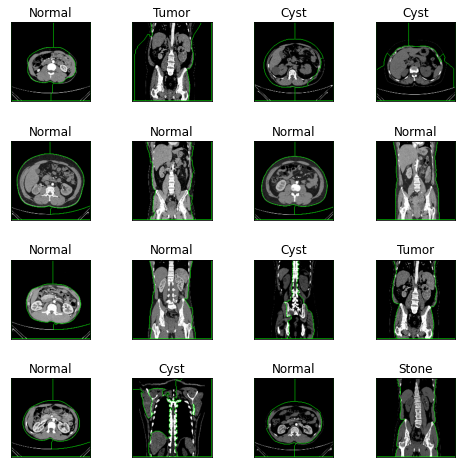

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1 , figsize = (8 , 8))
n = 0 
for i in range(16):
    n += 1 
    r = np.random.randint(0 , train_data.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

In [11]:
import tensorflow as tf
# Load the TensorBoard notebook extension (optional)
%load_ext tensorboard

#tf.random.set_random_seed(42)
tf.random.set_seed(42)
tf.__version__

'2.9.2'

In [12]:
# Normalization of data 
train_imgs_scaled = train_data / 255.
val_imgs_scaled = val_data / 255.
test_imgs_scaled = test_data / 255.

# encode text category labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)
test_labels_enc = le.transform(test_labels)

train_labels_enc = tf.keras.utils.to_categorical(train_labels_enc, 4)
val_labels_enc = tf.keras.utils.to_categorical(val_labels_enc, 4)
test_labels_enc = tf.keras.utils.to_categorical(test_labels_enc, 4)


# change version of tensorflow
#%tensorflow_version 2.x

print(train_labels[:6], train_labels_enc[:6])

['Cyst' 'Cyst' 'Tumor' 'Normal' 'Normal' 'Tumor'] [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]


Labels: ['Cyst', 'Cyst', 'Cyst', 'Cyst', 'Cyst']


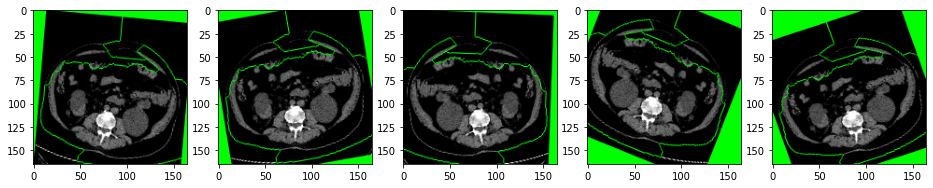

In [13]:
#Applying Data augmentation to images
BATCH_SIZE = 25
NUM_CLASSES = 4
EPOCHS = 25
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                zoom_range=0.05, 
                                                                rotation_range=25,
                                                                width_shift_range=0.05, 
                                                                height_shift_range=0.05, 
                                                                shear_range=0.05, horizontal_flip=True, 
                                                                fill_mode='nearest')

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
# check augmented images
img_id = 0
sample_generator = train_datagen.flow(train_data[img_id:img_id+1], train_labels[img_id:img_id+1],
                                      batch_size=1)
sample = [next(sample_generator) for i in range(0,5)]

fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in sample])
l = [ax[i].imshow(sample[i][0][0]) for i in range(0,5)]

# build image augmentation generators
train_generator = train_datagen.flow(train_data, train_labels_enc, batch_size=BATCH_SIZE, shuffle=True)
val_generator = val_datagen.flow(val_data, val_labels_enc, batch_size=BATCH_SIZE, shuffle=False)

# SqueezeNet Model

In [15]:
#!pip install keras_applications
#!pip install tensorflow --upgrade
#!pip install keras --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 3.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 578.0 MB 18 kB/s 
     |████████████████████████████████| 438 kB 64.7 MB/s 
     |████████████████████████████████| 5.9 MB 47.3 MB/s 
     |████████████████████████████████| 1.7 MB 58.9 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
from keras_applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, GlobalAveragePooling2D,BatchNormalization
from keras.models import Model
from keras.utils.layer_utils import get_source_inputs
from keras.utils import get_file
from keras.utils import layer_utils


sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

WEIGHTS_PATH = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_NO_TOP = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Modular function for Fire Node

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x


# Original SqueezeNet from paper.

def SqueezeNet(include_top=True, weights='imagenet',
               input_tensor=None, input_shape=None,
               pooling=None,
               classes=1000):
    """Instantiates the SqueezeNet architecture.
    """
        
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')


    input_shape = _obtain_input_shape(input_shape,
                                      default_size=227,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor


    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    
    if include_top:
        # It's not obvious where to cut the network... 
        # Could do the 8th or 9th layer... some work recommends cutting earlier layers.
    
        x = Dropout(0.5, name='drop9')(x)

        x = Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
        x = Activation('relu', name='relu_conv10')(x)
        x = GlobalAveragePooling2D()(x)
        x = Activation('softmax', name='loss')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling=='max':
            x = GlobalMaxPooling2D()(x)
        elif pooling==None:
            pass
        else:
            raise ValueError("Unknown argument for 'pooling'=" + pooling)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs, x, name='squeezenet')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
            
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model

In [17]:
snet = SqueezeNet(input_shape = INPUT_SHAPE, weights = 'imagenet', classes = 1000, include_top = False)

snet.trainable = True

set_trainable = False
for layer in snet.layers:
    if layer.name in ['fire8/squeeze1x1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

base_snet = snet
base_out = base_snet.output

pool_out = tf.keras.layers.Flatten()(base_out)

hidden1 = tf.keras.layers.Dense(512, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(256, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(4, activation='softmax')(drop2)

#sgd=SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)
#adam=Adam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#opt = tf.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
model = tf.keras.Model(inputs=base_snet.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
model.summary()

3032184/3032184 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 165, 165, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 82, 82, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 relu_conv1 (Activation)        (None, 82, 82, 64)   0           ['conv1[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)          

In [18]:
print("Total Layers:", len(model.layers))
print("Total trainable layers:", 
      sum([1 for l in model.layers if l.trainable]))

Total Layers: 68
Total trainable layers: 20


In [19]:
train_steps_per_epoch = train_generator.n // train_generator.batch_size
val_steps_per_epoch = val_generator.n // val_generator.batch_size
history = model.fit(train_generator,  epochs=EPOCHS, validation_data=val_generator,  verbose=1)

Epoch 1/25


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
315/315 [==============================] - ETA: 0s - loss: 1.6916 - accuracy: 0.4819

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
315/315 [==============================] - 62s 165ms/step - loss: 1.6916 - accuracy: 0.4819 - val_loss: 1.0941 - val_accuracy: 0.5716
Epoch 2/25
315/315 [==============================] - 46s 147ms/step - loss: 0.8803 - accuracy: 0.6550 - val_loss: 0.6229 - val_accuracy: 0.7514
Epoch 3/25
315/315 [==============================] - 46s 147ms/step - loss: 0.6671 - accuracy: 0.7370 - val_loss: 0.4676 - val_accuracy: 0.8259
Epoch 4/25
315/315 [==============================] - 46s 145ms/step - loss: 0.5168 - accuracy: 0.7942 - val_loss: 0.4082 - val_accuracy: 0.8465
Epoch 5/25
315/315 [==============================] - 49s 156ms/step - loss: 0.4505 - ac

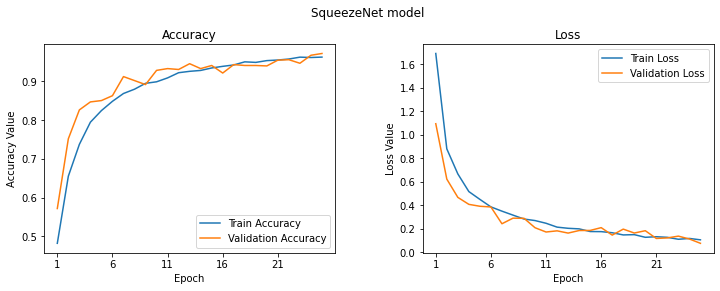

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('SqueezeNet model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [21]:
model.save('KidneyStoneDetector_squeezenet.h5')

In [ ]:
#scale test data
test_imgs_scaled.shape, test_labels_enc.shape

((3734, 165, 165, 3), (3734, 4))

In [22]:
score = model.evaluate(test_imgs_scaled, test_labels_enc, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.09478379040956497
Test accuracy: 0.9716577529907227
